In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
from glob import glob

"""Change to the data folder"""
train_path = ".\\new_train\\new2\\"
val_path = ".\\new_train\\ts\\"
predict_path = ".\\new_val_in\\new_val_in\\"
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data



# intialize a dataset
train_dataset  = ArgoverseDataset(data_path=train_path)
val_dataset = ArgoverseDataset(data_path=val_path)
predict_dataset = ArgoverseDataset(data_path=predict_path)

### Create a loader to enable batch processing

In [3]:
batch_sz = 256

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [scene['p_in'][scene['track_id'][:,0,0] == scene['agent_id']] for scene in batch]
    out = [scene['p_out'][scene['track_id'][:,0,0] == scene['agent_id']] for scene in batch]
    inp = torch.tensor(inp).squeeze()
    out = torch.tensor(out).squeeze()

    base = inp[:,0,:].clone().reshape(-1,1,2)
    inp = (inp - base).permute(1,0,2).to(dev)
    out = (out - base).permute(1,0,2).to(dev)

    return [inp, out]

train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)
val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

In [4]:
predict_batch_sz = 4

def my_predict_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    IDs = [scene['scene_idx'] for scene in batch]

    inp = [scene['p_in'][scene['track_id'][:,0,0] == scene['agent_id']] for scene in batch]
    inp = torch.tensor(inp).squeeze()
    
    base = inp[:,0,:].clone().reshape(-1,1,2).cpu()
    inp = (inp - base).permute(1,0,2).to(dev)

    return [inp, base, IDs]

predict_loader = DataLoader(predict_dataset,batch_size=predict_batch_sz, shuffle = False, collate_fn=my_predict_collate, num_workers=0)

In [5]:
print(len(train_loader))
print(len(val_loader))
print(len(predict_loader))
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    print(inp.shape)
    #print(inp)
    print(out.shape)
    #print(out)
    print()
    break

79
20
800
torch.Size([19, 256, 2])
torch.Size([30, 256, 2])



In [6]:
class Encoder(nn.Module):
    def __init__(self,
                 input_size = 2,
                 embedding_size = 128,
                 hidden_size = 256,
                 n_layers = 4,
                 dropout = 0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.linear = nn.Linear(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers,
                           dropout = dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        x: input batch data, size: [sequence len, batch size, feature size]
        for the argoverse trajectory data, size(x) is [19, batch size, 4]
        """
        # embedded: [sequence len, batch size, embedding size]
        embedded = self.dropout(F.relu(self.linear(x)))
        # you can checkout https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM
        # for details of the return tensor
        # briefly speaking, output coontains the output of last layer for each time step
        # hidden and cell contains the last time step hidden and cell state of each layer
        # we only use hidden and cell as context to feed into decoder
        output, (hidden, cell) = self.rnn(embedded)
        # hidden = [n layers * n directions, batch size, hidden size]
        # cell = [n layers * n directions, batch size, hidden size]
        # the n direction is 1 since we are not using bidirectional RNNs
        return hidden, cell
    

In [7]:
class Decoder(nn.Module):
    def __init__(self,
                 output_size = 2,
                 embedding_size = 128,
                 hidden_size = 256,
                 n_layers = 4,
                 dropout = 0.5):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Linear(output_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, dropout = dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, cell):
        """
        x : input batch data, size(x): [batch size, feature size]
        notice x only has two dimensions since the input is batchs
        of last coordinate of observed trajectory
        so the sequence length has been removed.
        """
        # add sequence dimension to x, to allow use of nn.LSTM
        # after this, size(x) will be [1, batch size, feature size]
        x = x.unsqueeze(0)

        # embedded = [1, batch size, embedding size]
        embedded = self.dropout(F.relu(self.embedding(x)))

        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hidden size]
        #hidden = [n layers, batch size, hidden size]
        #cell = [n layers, batch size, hidden size]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        # prediction = [batch size, output size]
        prediction = self.linear(output.squeeze(0))

        return prediction, hidden, cell
    

In [8]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, x, y, teacher_forcing_ratio = 0.5):
        """
        x = [observed sequence len, batch size, feature size]
        y = [target sequence len, batch size, feature size]
        for our argoverse motion forecasting dataset
        observed sequence len is 19, target sequence len is 30
        feature size for now is just 4 (x and y)

        teacher_forcing_ratio is probability of using teacher forcing
        e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        """
        batch_size = x.shape[1]
        target_len = y.shape[0]
        
        # tensor to store decoder outputs of each time step
        outputs = torch.zeros(y.shape).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(x)

        # first input to decoder is last coordinates of x
        decoder_input = x[-1, :, :]
        
        for i in range(target_len):
            # run decode for one time step
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)

            # place predictions in a tensor holding predictions for each time step
            outputs[i] = output

            # decide if we are going to use teacher forcing or not
            teacher_forcing = random.random() < teacher_forcing_ratio

            # output is the same shape as input, [batch_size, feature size]
            # so we can use output directly as input or use true lable depending on
            # teacher_forcing is true or not
            decoder_input = y[i] if teacher_forcing else output

        return outputs

In [9]:
INPUT_DIM = 2
OUTPUT_DIM = 2
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 4
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, dev).to(dev)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,949,826 trainable parameters


In [11]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, (x, y) in enumerate(dataloader):
        if i % 40 == 0:
            print(i)
        # put data into GPU
        x = x.to(dev)
        y = y.to(dev)
        #print(x.shape)
        #print(y.shape)
        # zero all param gradients
        optimizer.zero_grad()
        
        # run seq2seq to get predictions
        y_pred = model(x.float(), y.float())
        
        # get loss and compute model trainable params gradients though backpropagation
        loss = criterion(y_pred, y.float())
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # add batch loss, since loss is single item tensor
        # we can get its value by loss.item()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [12]:
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(dev)
            y = y.to(dev)
            
            # turn off teacher forcing
            y_pred = model(x.float(), y.float(), teacher_forcing_ratio = 0)
            
            loss = criterion(y_pred, y.float())
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [20]:
def testtt(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.float().to(dev)
            y = y.float().to(dev)
            
            # turn off teacher forcing
            y_pred = model(x.float(), y, teacher_forcing_ratio = 0)
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()
            if i == 1:
                print(x.transpose(0, 1)[0])
                print(torch.cat((y.transpose(0, 1)[0], y_pred.transpose(0, 1)[0]), 1))
                break
                
    return epoch_loss / len(dataloader)

In [14]:
import pandas as pd

def writefinal(model, dataloader):
    model.eval()
    epoch_loss = 0
    f = open('output.csv', 'a', newline = '\n')
    header = np.array(['ID'] + ['v' + str(i) for i in range(1,61)]).reshape(1,-1)
    np.savetxt(f, header,fmt='%s', delimiter=',')

    with torch.no_grad():
        for i, (x, base, IDs) in enumerate(dataloader):
            x = x.float().to(dev)
            y = torch.zeros(30,x.shape[1],2).float().to(dev)
            # turn off teacher forcing
            y_pred = model(x, y, teacher_forcing_ratio = 0)
            #print(y_pred)
            #loss = criterion(y_pred, y)
            #epoch_loss += loss.item()
            y_pred = np.array(y_pred.squeeze().permute(1,0,2).cpu() + base)
            
            y_pred = np.hstack((np.array(IDs).reshape(-1,1), y_pred.reshape(-1,60)))
            y_pred = pd.DataFrame(y_pred)
            y_pred[0] = y_pred[0].astype(int)
            y_pred.to_csv(f, header=False, index = False)
            if i % 200 == 0:
                print(i)
            
    f.close()
    #return epoch_loss / len(dataloader)

### Visualize the batch of sequences

In [15]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
import os
import time
N_EPOCHES = 50
best_val_loss = float('inf')

# load previous best model params if exists

model_dir = "saved_models/Seq2Seq"
saved_model_path = model_dir + "/best_seq2seq.pt"
if os.path.isfile(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path))
    print("successfully load previous best model parameters")

for epoch in range(N_EPOCHES):
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    
    mins, secs = epoch_time(start_time, end_time)
    
    print(F'Epoch: {epoch+1:02} | Time: {mins}m {secs}s')
    print(F'\tTrain Loss: {train_loss:.3f}')
    print(F'\t Val. Loss: {val_loss:.3f}')

    if val_loss < best_val_loss:
        os.makedirs(model_dir, exist_ok=True)
        torch.save(model.state_dict(), saved_model_path)
"""
model_dir = "saved_models/Seq2Seq"
saved_model_path = model_dir + "/best_seq2seq.pt"
os.makedirs(model_dir, exist_ok=True)
torch.save(model.state_dict(), saved_model_path)
"""

successfully load previous best model parameters
0
40
Epoch: 01 | Time: 1m 8s
	Train Loss: 10.534
	 Val. Loss: 20.030
0


KeyboardInterrupt: 

In [87]:
model_dir = "saved_models/Seq2Seq"
saved_model_path = model_dir + "/best_seq2seq.pt"
if os.path.isfile(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path))
    print("successfully load previous best model parameters")
writefinal(model, predict_loader)

successfully load previous best model parameters
0
200
400
600


In [21]:
model_dir = "saved_models/Seq2Seq"
saved_model_path = model_dir + "/best_seq2seq.pt"
if os.path.isfile(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path))
    print("successfully load previous best model parameters")
val_loss = testtt(model, val_loader, criterion)

successfully load previous best model parameters
tensor([[  0.0000,   0.0000],
        [  0.0455,  -1.4324],
        [  0.2136,  -4.2571],
        [  0.4678,  -5.9634],
        [  0.6055,  -7.0022],
        [  0.8210, -10.4019],
        [  0.9728, -11.9463],
        [  0.9756, -13.4277],
        [  1.1077, -14.7639],
        [  1.2413, -17.6355],
        [  1.4758, -18.8992],
        [  1.6583, -20.6545],
        [  1.7065, -23.9756],
        [  1.8201, -25.2573],
        [  1.9539, -26.6968],
        [  1.9980, -28.1606],
        [  2.1133, -29.8105],
        [  2.2244, -31.4883],
        [  2.3692, -34.6809]], device='cuda:0')
tensor([[  2.4252, -36.0903,   2.7293, -33.6567],
        [  2.5048, -37.6985,   1.4521, -36.2808],
        [  2.5717, -39.2524,   0.8036, -37.7156],
        [  2.6609, -40.9473,   1.1066, -39.1282],
        [  2.6849, -42.4424,   1.4654, -40.8353],
        [  2.9122, -45.3745,   1.5371, -42.3214],
        [  2.9583, -46.9492,   1.4072, -43.4989],
        [  3.

<ipython-input-3-e34a6e23e746>:7: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  inp = torch.LongTensor(inp)
<ipython-input-3-e34a6e23e746>:8: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  out = torch.LongTensor(out)


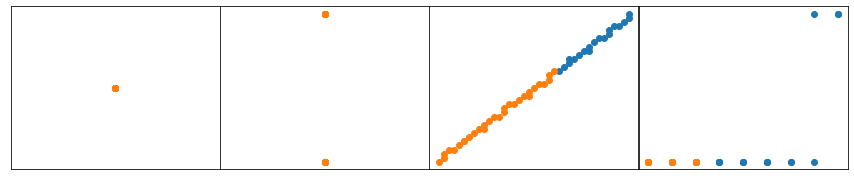

In [4]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

        
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch(sample_batch, agent_id)
    break